**Описание проекта**

Даны массивы данных крупного интернет-магазина:

Данные для первой части состоят из одного датасета hypothesis.csv со столбцами:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части состоят из двух датасетов: orders.csv со столбцами:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

и visitors.csv со столбцами:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Подготовлен список гипотез для увеличения выручки.
Нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
 
register_matplotlib_converters()


In [2]:
try:
    hypothesis = pd.read_csv('datasets/hypothesis.csv')
    orders = pd.read_csv('datasets/orders.csv', sep=',')
    visitors = pd.read_csv('datasets/visitors.csv', sep=',')
except:   
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', sep=',')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', sep=',')

In [3]:
display(hypothesis.info(), orders.info(), visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

None

None

None

переименуем столбцы

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
orders = orders.rename(columns={'transactionId':'transaction_id',
                        'visitorId':'visitor_id'})

In [6]:
display(hypothesis.head(), orders.head(), visitors.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


сделаем проверку на явные дубликаты

In [7]:
hypothesis.duplicated(subset=None, keep='first').value_counts()

False    9
dtype: int64

In [8]:
orders.duplicated(subset=None, keep='first').value_counts()

False    1197
dtype: int64

In [9]:
visitors.duplicated(subset=None, keep='first').value_counts()

False    62
dtype: int64

приведем даты к соответствующему типу данных

In [10]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [11]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

In [12]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

visitors['date'].min()

Timestamp('2019-08-01 00:00:00')

In [13]:
visitors['date'].max()

Timestamp('2019-08-31 00:00:00')

проверим, есть ли в датасете пользователи, которые попали в обе группы

In [14]:
a = orders.query('group=="A"')
a

,transaction_id,visitor_id,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
10,3649131742,879864040,2019-08-15,4008,A
12,2809384911,3213223594,2019-08-15,7370,A
...,...,...,...,...,...
1187,2274188238,132143192,2019-08-14,750,A
1188,1692103379,1022829655,2019-08-14,112,A
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [15]:
b = orders.query('group=="B"')
b

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1189,4082620617,393266494,2019-08-14,31550,B
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B


In [16]:
c = list(set(a['visitor_id']) & set(b['visitor_id']))

len(c)

58

обнаружено 58 пользователей, и их нужно отфильтровать

In [17]:
orders = orders.query('visitor_id not in @c')

orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


Теперь данные не содержат пропусков и дубликатов, датафреймы содержат данные с 1 по 31 августа 2019 г

**Часть 1. Приоритизация гипотез**

В файле с гипотезами имеется 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами 

Нужно: 

Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

In [18]:
hypothesis
pd.options.display.max_colwidth = 1

In [19]:
hypothesis['ICE']=round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],3)

print(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

                                                                                                     hypothesis  \
8  Запустить акцию, дающую скидку на товар в день рождения                                                        
0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей             
7  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок               
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию           
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1  Запустить собственную службу доставки, что сократит срок доставки заказов                                      
5  Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                       
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстр

In [20]:
hypothesis['RICE']=hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

print(hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

                                                                                                     hypothesis  \
7  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок               
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей             
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию           
8  Запустить акцию, дающую скидку на товар в день рождения                                                        
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар            
1  Запустить собственную службу доставки, что сократит срок доставки заказов                                      
5  Добавить страницу отзывов клиентов о магазине, что позволит увеличить количес

Приоритизация гипотез при применении RICE вместо ICE изменилась, поскольку на RICE влияет параметр reach, который отражает охват пользователей.

**Часть 2. Анализ A/B-теста**

Строим график кумулятивной выручки по группам

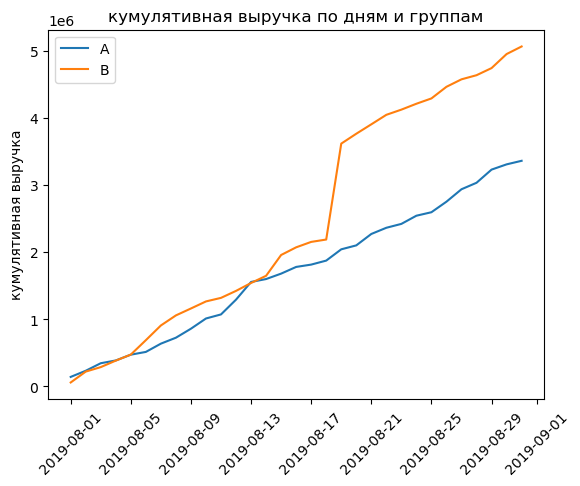

In [21]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)

plt.ylabel('кумулятивная выручка')
plt.legend()
plt.title('кумулятивная выручка по дням и группам')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Однако график выручки группы В в одной точке резко подрастает. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

Построим график кумулятивного среднего чека по группам

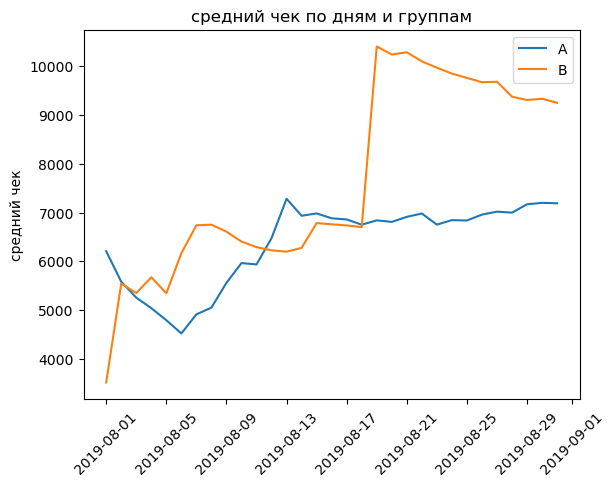

In [22]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.xticks(rotation=45)
plt.ylabel('средний чек')
plt.legend()
plt.title('средний чек по дням и группам')
plt.show()

Средний чек группы А резко подрастает в двух точках в первой половине теста, затем начинает стабилизироваться.
Средний чек группы В резко подрастает в одной точке, во второй половине теста, затем начинает плавно снижаться к концу теста. Возможно, в группу А в первой половине теста, а в группу В во второй половине, попали крупные заказы.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

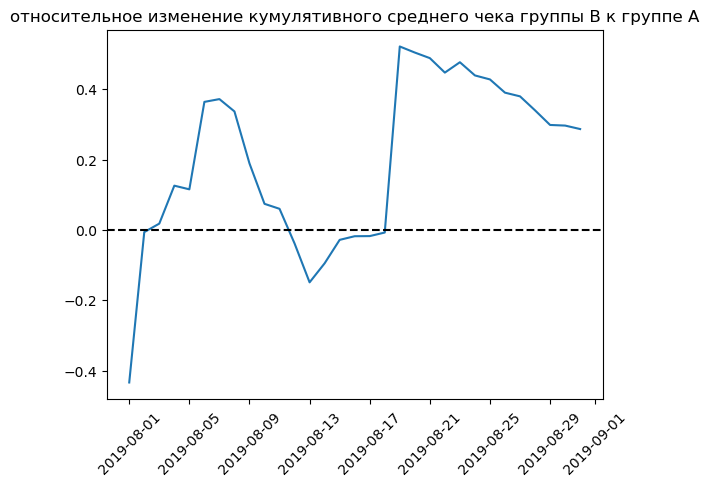

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45)
plt.title('относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

В нескольких точках график различия между сегментами резко скачет. Где-то есть крупные заказы и выбросы.

Построим график кумулятивного среднего количества заказов на посетителя по группам. 

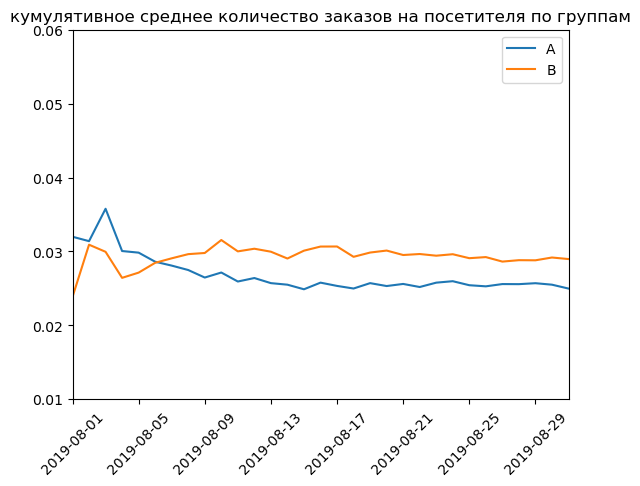

In [24]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.axis(['2019-08-01', '2019-08-31', 0.01, 0.06])
plt.legend()

plt.xticks(rotation=45)
plt.title('кумулятивное среднее количество заказов на посетителя по группам')
plt.show()

Сначала группы колебались около одного значения, но затем конверсия группы A просела и зафиксировалась, а конверсия группы B выросла и также зафиксировалась.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

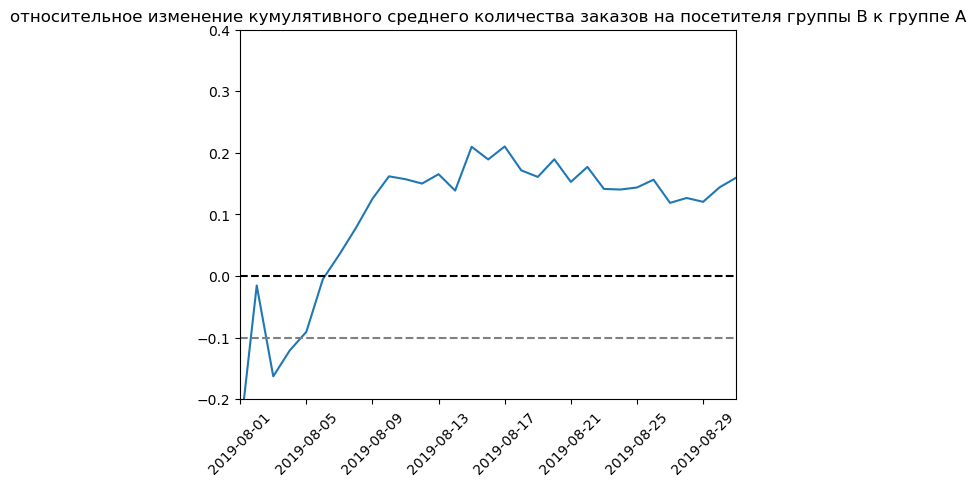

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
#plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.axis(['2019-08-01', '2019-08-31', -0.2, 0.4])

plt.xticks(rotation=45)
plt.title('относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд и теперь значительно выше

Построим точечный график количества заказов по пользователям.

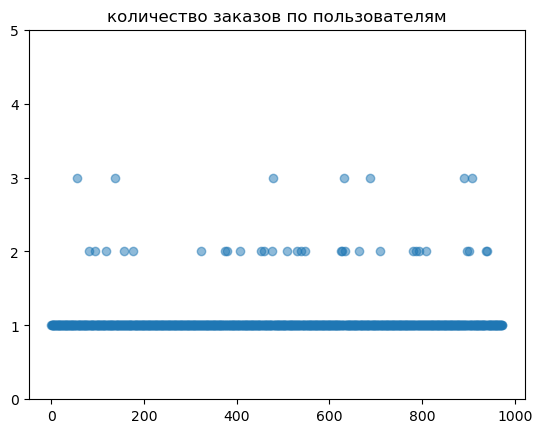

In [26]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'], alpha =0.5)

plt.title('количество заказов по пользователям')
plt.ylim([0, 5])
plt.show()

посчитаем 95 и 99 перцентили

In [27]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

не более 5% совершали более 1 заказа, не более 1% совершали более двух заказов, установим верхнюю границу в 2 заказа

Построим точечный график стоимостей заказов

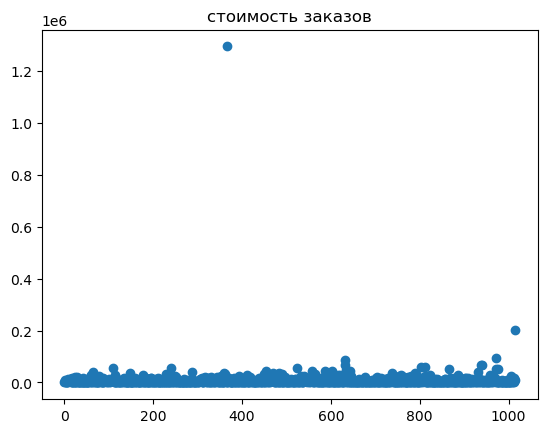

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('стоимость заказов')
plt.show()

На точечном графике видны выбросы: один заказ на ~1.3 млн, а также один заказ более 200 тыс.

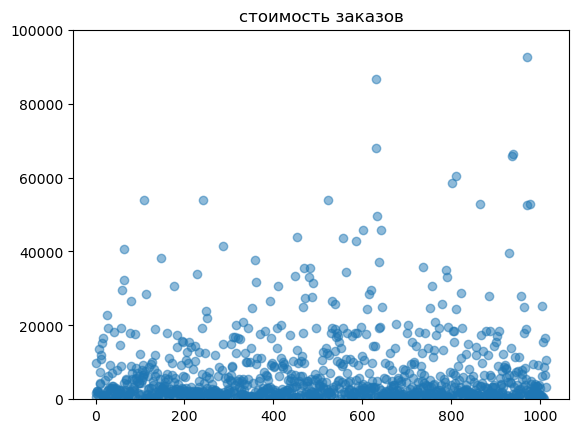

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('стоимость заказов')
plt.ylim([0, 100000])
plt.show()

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов

In [30]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов дороже 26 785 и не более 1% дороже 53904, установим верхнюю границу в 26785

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Предварительно соберем необходимые данные в переменную data:

In [31]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01  19              142779           17               
1 2019-08-02  18              91602            22               
2 2019-08-03  24              112473           14               
3 2019-08-04  11              41176            13               
4 2019-08-05  22              86383            21               

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0  59758            19                  142779                
1  162043           37                  234381                
2  67049            61                  346854                
3  96890            72                  388030                
4  89908            94                  474413                

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0  17                  59758                719                
1  39                  221801               619                
2  53                  288850         

сормулируем гипотезы:
    
Н0: различий в среднем количестве заказов между группами нет

Н1: различия в среднем количестве заказов между группами есть

и
    
Н0: различий в среднем чеке между группами нет 

Н1: различия в среднем чеке между группами есть

Применим статистический критерий Манна-Уитни к полученным выборкам.
Зададим уровень статистической значимости 0.05

In [32]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}) #'transaction_id', 'visitor_id'
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('различие в количестве заказов:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
различие в количестве заказов: 0.160


p-value = 0.011. Значит отвергаем нулевую гипотезу о том, что нет различия в среднем числе заказов между группами. В группе B на 16% больше заказов.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [33]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('различие в среднем чеке:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
различие в среднем чеке: 0.287


p-value значительно больше 0.05. Значит, не отвергаем гипотезу о том, что в среднем чеке нет различий. Средний чек группы B на 28.7% выше среднего чека группы A.

Посчитаем количество аномальных пользователей

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [95]))]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
58


Всего 58 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста.
Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('различие в количестве заказов', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.012
различие в количестве заказов 0.182


p-value = 0.012. Значит отвергаем нулевую гипотезу о том, что нет различия в среднем числе заказов между группами.  После фильтрации в группе B на 18.2% больше заказов.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным 

In [36]:
print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('различие в среднем чеке:', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.646
различие в среднем чеке: -0.048


p-value по-прежнему значительно больше 0.05. Значит, не отвергаем гипотезу о том, что в среднем чеке нет различий. После фильтрации средний чек группы B на 4.8% ниже среднего чека группы A.

**Выводы:**

- В ходе работы были обработаны исхоные данные, выполнена проверка на наличие пропусков и дубликатов;
- Из анализа удалены пользователи, попавшие в обе группы;
- Установлено, что наиболее приоритетными по параметру RICE являются гипотезы 7 и 2:

(7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

(2)  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

- Получены графики изменения количества заказов и выручки по группам. Найдены аномальные значения стоимости и количества заказов. Установлены границы аномальных значений стоимости и количества заказов.

- Гипотеза о том, что нет различия в среднем числе заказов между группами отвергнута;

- По очищенным данным в сегменте B на 18.2% больше заказов;

- Не получилось отвергнуть гипотезу о том, что в среднем чеке нет различий;
 
- После выброса аномальных значений средний чек в группе В на 4.8% меньше чем в А;


Исходя из обнаруженных фактов, следует остановить тест и зафиксировать победу группы В, так как, несмотря на чуть меньшее значение среднего чека, количесвто заказов в группе В существенно выросло.